In [7]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import cm

In [8]:
m = 800 # number of points, default 2000
n = 3 # representation dimension
t = 1 # number of neighbors measured, default 10

In [9]:
def t_nearest_matr(m, t, X):
    t_nearest = np.ones((m, t), dtype=int) * 1
    for id, row in enumerate(X.T):
        dif = X.T - row # get vector representation-wise differences
        norm_indices = np.argsort(np.linalg.norm(dif, axis = 1))
        t_nearest[id] = norm_indices[1: t + 1] # exclude the row itself
    return t_nearest # returns m x t matrix representing t_nearest

In [10]:
def weight_matr(m, N, X, sigma):
    X = X.T # transpose the data matrix for ease in W_ij calculation
    W = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if (i in N[j]) or (j in N[i]):
                W[i][j] = np.exp(-np.linalg.norm(X[i] - X[j]) / (sigma ** 2))
    return W

In [11]:
def diag_matr(m, W):
    D = np.zeros((m, m))
    for i in range(m):
        D[i][i] = np.sum(W[i])
    return D

In [12]:
def get_le_reduced(k, X, W):
    m = len(X[0])
    D = diag_matr(m, W)
    L = D - W

    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvectors[-k:] # smallest k eigenvectors (rows)

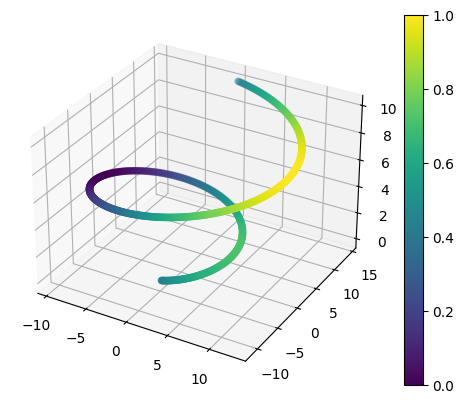

In [13]:
theta = np.linspace(1.5 * np.pi, 4.5 * np.pi, m) # 1.5 to 4.5 default
r = np.linspace(0, 10, m)
x = theta * np.cos(theta)
z = r
y = theta * np.sin(theta)
# fig = plt.figure()
gradient_colors = x

# Normalize the gradient_colors to be between 0 and 1
min_color = np.min(gradient_colors)
max_color = np.max(gradient_colors)
normalized_colors = (gradient_colors - min_color) / (max_color - min_color)

# Create a colormap
colormap = cm.viridis

# Create an interpolated color gradient based on the normalized_colors
interpolated_colors = colormap(normalized_colors)

# Plot the original data points in 3D with the interpolated color gradient
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=interpolated_colors)
fig.colorbar(sc)
plt.show()

In [14]:
X = np.vstack((x, y, z))
X.shape

(3, 800)

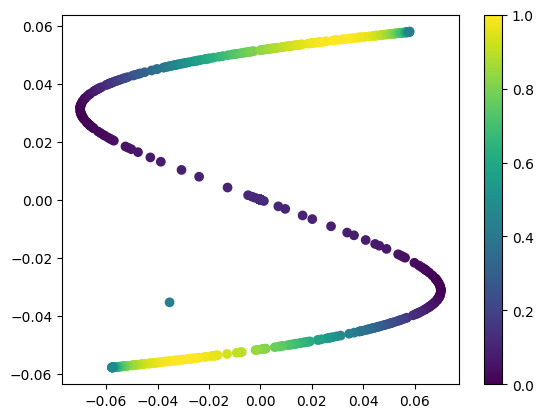

In [15]:
k = 2  # projection dimension
sigma = 0.3 # hyperparameter, 0.2 seems to work best
N = t_nearest_matr(m, t, X)
W = weight_matr(m, N, X, sigma)
P = get_le_reduced(k, X, W)

# Plot the reduced data points in 2D with the same color gradient
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(P[0, :], P[1, :], c=interpolated_colors) #, cmap=colormap, marker='o')
fig.colorbar(sc)

plt.show()

We wish to compare the "Averaged Laplacian Eigenmap" algorithm to the standard
algorithm used by embedding a helix in 2D space. 

In [16]:
print(f"P has shape {P.shape}")

P has shape (2, 800)


In [17]:
def avg_distance_matr(m, t, X, N):
    avgs = np.zeros((m,))
    for l in range(m):
        for j in range(t):
            avgs[l] += np.sum((X.T[l] - X.T[N[l][j]]) ** 2)
    return np.sqrt(avgs) / t

In [18]:
def averaged_laplacian_weight(m, t, X, N, avgs):
    X = X.T
    W = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if (i in N[j]) or (j in N[i]):
                W[i][j] = np.exp(-(np.linalg.norm(X[i] - X[j]) ** 2) / (t * avgs[i] * avgs[j]))
    return W
# Please note that broadcoasting the np.exp, np.square, and /t operations produces different results

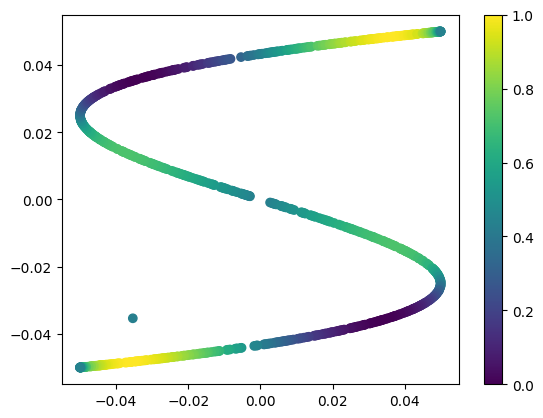

In [19]:
k = 2  # projection dimension
t = 1 # nearest neighbors
N = t_nearest_matr(m, t, X)
avgs = avg_distance_matr(m, t, X, N)
W = averaged_laplacian_weight(m, t, X, N, avgs)
P = get_le_reduced(k, X, W)

# Plot the reduced data points in 2D with the same color gradient
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(P[0, :], P[1, :], c=interpolated_colors) #, cmap=colormap, marker='o')
fig.colorbar(sc)

plt.show()

In [20]:
def variable_nbrs_weight(m, t, X, N, avgs):
    z = np.mean(np.exp(1 / avgs))
    # print(f"avgs is {avgs}")
    radius_matrix = 1 + t * np.exp(1 / avgs) / z
    radius_matrix = radius_matrix.astype(int)
    # print(f"radius matrix is {radius_matrix}")
    W = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if (i in N[j][:radius_matrix[j]]) or (j in N[i][:radius_matrix[i]]):
                W[i][j] = np.exp(-(np.linalg.norm(X.T[i] - X.T[j]) ** 2) / (t * avgs[i] * avgs[j]))
    return W
    # return W

In [21]:
radius = 5

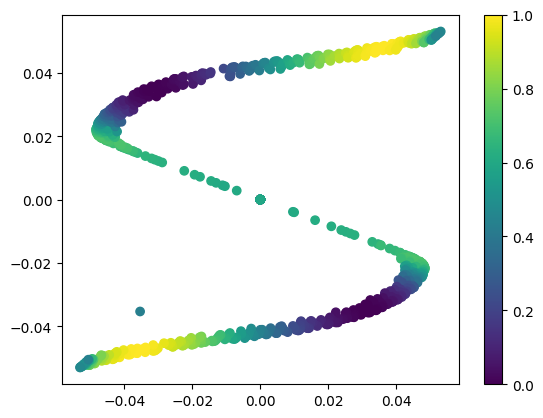

In [22]:
k = 2 # projection dimension
N = t_nearest_matr(m, radius, X)
avgs = avg_distance_matr(m, radius, X, N)
W = variable_nbrs_weight(m, radius, X, N, avgs)
P = get_le_reduced(k, X, W)

# Plot the reduced data points in 2D with the same color gradient
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(P[0, :], P[1, :], c=interpolated_colors) #, cmap=colormap, marker='o')
fig.colorbar(sc)

plt.show()

In [23]:
P.shape

(2, 800)